In [1]:
import numpy as np

from gavlib.io import import_out_struct

In [2]:
filepath = '../../../projects/dstrf/data/out_structures/out_HG_LIJ113_holm.mat'
out = import_out_struct(filepath)

In [3]:
# Let's look at the data we have
print(len(out)) # number of trials/stimuli recorded
print(out.fields) # data fields available for each trial


19
['name', 'sound', 'soundf', 'dataf', 'duration', 'befaft', 'type', 'resp', 'artifact', 'trial', 'ti', 'label', 'reverb', 'prelabel', 'significant_elecs_from_bahars']


In [4]:
# We can also iterate over the trials and get interesting information
for t, trial in enumerate(out[:3]): # only look at the first 3 trials
    print(f'trial {t}-----')
    print(type(trial)) # each trial is a dictionary object
    print(trial['name']) # we can access a single field of this trial, like the name


trial 0-----
<class 'dict'>
stim01
trial 1-----
<class 'dict'>
stim02
trial 2-----
<class 'dict'>
stim03


In [5]:
# we can also access a single field of all the trials by using out.get_field()
print([resp.shape for resp in out.get_field('resp')]) # shape of each trial: (num_elecs * time)

[(30, 6197), (30, 5203), (30, 6430), (30, 6206), (30, 6560), (30, 7194), (30, 8540), (30, 6586), (30, 5904), (30, 5621), (30, 8707), (30, 7602), (30, 4977), (30, 3751), (30, 3485), (30, 3778), (30, 2979), (30, 2986), (30, 448)]


If we have some more data, labels, or something that we want to store in our OutStruct as well, we can add a field to the OutStruct. To add a field, you must pass in either a list of the same length as the OutStruct which contains the data for this field for each trial, or a multidimensional array where the first index is the length of the OutStruct

In [6]:
# for example, let's add a new name for each and call the field "test_name"
new_field_data = [f'test{i}' for i in range(19)]
out.set_field(new_field_data, fieldname='test_name')
print(out.fields) # now we have a new field
print(out[0]['test_name']) # let's print the data in this field for the first trial

['name', 'sound', 'soundf', 'dataf', 'duration', 'befaft', 'type', 'resp', 'artifact', 'trial', 'ti', 'label', 'reverb', 'prelabel', 'significant_elecs_from_bahars', 'test_name']
test0


### Processing an OutStruct

In [7]:
# now let's zscore the response data over time (and across all trials)
from gavlib.preprocessing import normalize

norm_resp = normalize(outstruct=out, data='resp', axis=-1, method='zscore')


In [8]:
# we can also directly pass in the field as the data

norm_resp2 = normalize(data=out.get_field('resp'), axis=-1, method='zscore')


In [9]:
# print out the standard deviation before and after normalization
# Note: the standard dev. is not exactly 1 because it was computed over the full out struct,
# not for each trial individually

print(out[0]['resp'].std(axis=-1))
print(norm_resp[0].std(axis=-1))
print(norm_resp2[0].std(axis=-1))

[0.82153982 1.13056419 1.46729383 1.63991529 1.80746745 1.6620427
 1.49965842 1.54505928 1.47529691 1.35430757 1.23219641 1.25273965
 1.30835683 0.95506827 0.82565716 0.74135743 0.8675098  1.09265345
 1.18879407 1.26099978 1.24296696 1.20067893 1.51760834 1.74466428
 1.94255046 1.80243959 1.20675949 0.88059825 0.90514038 1.09985971]
[0.82046506 0.96945641 1.07992902 1.11316762 1.11249377 1.07419394
 1.02577959 1.06583431 1.11442683 1.12698377 1.08298257 1.08600933
 1.07794006 0.92745478 0.91390538 0.86545181 0.95008439 1.03271206
 1.03436409 1.00737443 1.045131   1.03296959 1.13533031 1.12382104
 1.15945381 1.1279667  1.05699912 0.97674993 0.97234702 1.01658648]
[0.82046506 0.96945641 1.07992902 1.11316762 1.11249377 1.07419394
 1.02577959 1.06583431 1.11442683 1.12698377 1.08298257 1.08600933
 1.07794006 0.92745478 0.91390538 0.86545181 0.95008439 1.03271206
 1.03436409 1.00737443 1.045131   1.03296959 1.13533031 1.12382104
 1.15945381 1.1279667  1.05699912 0.97674993 0.97234702 1.016

In [10]:
# looks good, so let's replace the 'resp' field in our outstruct with this new normalized resp
out.set_field(norm_resp, fieldname='resp')
print(out[0]['resp'].std(axis=-1)) # now the normalized data is in the 'resp' field

[0.82046506 0.96945641 1.07992902 1.11316762 1.11249377 1.07419394
 1.02577959 1.06583431 1.11442683 1.12698377 1.08298257 1.08600933
 1.07794006 0.92745478 0.91390538 0.86545181 0.95008439 1.03271206
 1.03436409 1.00737443 1.045131   1.03296959 1.13533031 1.12382104
 1.15945381 1.1279667  1.05699912 0.97674993 0.97234702 1.01658648]


### Segmenting responses based on transitions between different labels

In this task, the noise in the background changed every 3-6 seconds. The current noise in the background is given by the "label" field of the outstruct. We can use this field to segment the responses around the label changes.

In [11]:
from gavlib.segmentation import segment_around_labeltransitions

# to use the segmentation, response data must be transposed so time is first axis
out.set_field([r.transpose() for r in out.get_field('resp')], fieldname='resp_transpose')

# segment and return chunks with 50 samples before the transition and 300 samples after
resp_segments, labels, prior_labels = segment_around_labeltransitions(outstruct=out, data='resp_transpose',
                                                                      labels='label', prechange_samples=50,
                                                                      postchange_samples=300)


In [12]:
# let's look at what we have
print(resp_segments.shape) # num_segments * time * electrodes
print(labels.shape) # num_segments,
print(prior_labels.shape) # num_segments,

(301, 350, 30)
(301,)
(301,)


### Visualization with shadederrorplot

Let's make a quick plot of the average response over all electrodes to the transitions, and to a specific transition type

In [17]:
import matplotlib.pyplot as plt
from gavlib.visualization import shadederrorplot

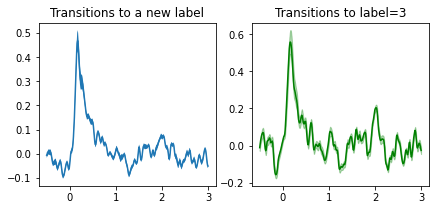

In [27]:
fig, axes = plt.subplots(1,2,figsize=(7,3))

x = np.linspace(-0.5, 3, 350)

# average over all transitions and input the time-by-electrodes data
shadederrorplot(x, resp_segments.mean(0), ax=axes[0])
axes[0].set_title('Transitions to any new label')

# now, average over all the transitions to just one label type
# change some parameters for second plot
plt_args = {'color': 'g'}
shade_args = {'color': 'g', 'alpha': 0.3}
shadederrorplot(x, resp_segments[labels==3].mean(0), plt_args=plt_args, shade_args=shade_args, ax=axes[1])
axes[1].set_title('Transitions to label=3')

plt.show()

